# **STOKES ELEMENT TESTING**

## **Imports**

### Firedrake

In [1]:
try:
    !wget "https://fem-on-colab.github.io/releases/firedrake-install-release-real.sh" -O "/tmp/firedrake-install.sh"
    !bash "/tmp/firedrake-install.sh"
    from firedrake import *  # noqa: F401
except:
    from firedrake import *  # noqa: F401

--2026-01-01 19:03:26--  https://fem-on-colab.github.io/releases/firedrake-install-release-real.sh
Resolving fem-on-colab.github.io (fem-on-colab.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to fem-on-colab.github.io (fem-on-colab.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4767 (4.7K) [application/x-sh]
Saving to: ‘/tmp/firedrake-install.sh’

/tmp/firedrake-inst 100%[===================>]   4.66K  --.-KB/s    in 0s      

2026-01-01 19:03:27 (36.9 MB/s) - ‘/tmp/firedrake-install.sh’ saved [4767/4767]

+ INSTALL_PREFIX=/usr/local
++ echo /usr/local
++ awk -F/ '{print NF-1}'
+ INSTALL_PREFIX_DEPTH=2
+ PROJECT_NAME=fem-on-colab
+ SHARE_PREFIX=/usr/local/share/fem-on-colab
+ FIREDRAKE_INSTALLED=/usr/local/share/fem-on-colab/firedrake.installed
+ [[ ! -f /usr/local/share/fem-on-colab/firedrake.installed ]]
+ PYBIND11_INSTALL_SCRIPT_PATH=https://github.com/fem-on-colab/fem-on-colab.github.io/raw/ff61

### Other

In [4]:
import matplotlib.pyplot as plt

# **Code**

In [27]:
def solve_stokes_eigenproblem(mesh_type="l-shaped", refinement_level=4, degree=2, sigma_val=20.0, ds_degree=None, penalty_only=False, n_eigenvalues=6, n_eigenfunctions=0):
    """
    Solves the Stokes eigenproblem using a streamfunction formulation.

    Parameters:
    - mesh_type: "square" or "l-shaped"
    - refinement_level: Number of refinements to apply to the base mesh
    - degree: Polynomial degree for the streamfunction (CG space)
    - n_eigenvalues: Number of eigenvalues to compute
    - sigma_val: Penalty parameter for the biharmonic form
    - plot_eigenfunctions: Whether to display contour plots of the eigenfunctions
    """

    # 1. Mesh Definition
    if mesh_type == "square":
        # Base mesh is 1x1
        mesh = UnitSquareMesh(1, 1)
    elif mesh_type == "l-shaped":
        coords = np.array([
            [0.0, 0.0],  [1.0, 0.0],  [1.0, 1.0],   [0.0, 1.0],
            [-1.0, 1.0], [-1.0, 0.0], [-1.0, -1.0], [0.0, -1.0]
        ], dtype=float)
        cells = np.array([
            [0, 1, 2], [0, 2, 3],     # top right
            [0, 3, 4], [0, 4, 5],     # top left
            [0, 5, 6], [0, 6, 7],     # bottom left
        ], dtype=np.int32)
        plex = PETSc.DMPlex().createFromCellList(
            2, cells, coords, interpolate=True, comm=PETSc.COMM_WORLD
        )
        mesh = Mesh(plex)
    else:
        raise ValueError(f"Unknown mesh type: {mesh_type}")
    if refinement_level > 0:
        mesh = MeshHierarchy(mesh, refinement_level)[-1]

    print(GREEN % f"Mesh: {mesh_type} | Refinement level: {refinement_level} | Degree: {degree} | Sigma: {sigma_val}")

    # 2. Function Spaces
    V = FunctionSpace(mesh, "CG", degree)

    # 3. Trial and Test Functions
    psi = TrialFunction(V)
    phi = TestFunction(V)

    u = curl(psi)
    v = curl(phi)

    # 4. Variational Form
    n = FacetNormal(mesh)
    h = CellDiameter(mesh)
    sigma = Constant(sigma_val)

    def a_biharmonic(u, v):
        dev = lambda u_ref : sym(grad(u_ref))
        jump_dev = lambda u_ref : 2 * avg(sym(outer(u_ref, n)))

        ds_ = ds if (ds_degree is None) else ds(degree=ds_degree)
        dS_ = dS if (ds_degree is None) else dS(degree=ds_degree)

        if penalty_only:
            term = 2 * inner(jump_dev(u), jump_dev(v)) * dS_
            term += 2 * inner(sym(outer(u, n)), sym(outer(v, n))) * ds_
        else:
            # Volume term: 2 * dev(u) : dev(v)
            term = 2 * inner(dev(u), dev(v)) * dx

            # Interior Facets
            term -= 2 * inner(avg(dev(u)), jump_dev(v)) * dS_
            term -= 2 * inner(avg(dev(v)), jump_dev(u)) * dS_
            term += 2 * (sigma / avg(h)) * inner(jump_dev(u), jump_dev(v)) * dS_

            # Boundary Facets (Weak imposition of no-slip BC u=0)
            term -= 2 * inner(1/2 * dev(u), sym(outer(v, n))) * ds_
            term -= 2 * inner(1/2 * dev(v), sym(outer(u, n))) * ds_
            term += 2 * (sigma / h) * inner(sym(outer(u, n)), sym(outer(v, n))) * ds_

        return term

    A = a_biharmonic(u, v)
    M = inner(u, v) * dx

    # 5. Solver
    # Boundary conditions: psi = 0 on boundary (u.n = 0)
    bcs = [DirichletBC(V, 0, "on_boundary")]

    eigenproblem = LinearEigenproblem(A, M, bcs=bcs)

    solver = LinearEigensolver(eigenproblem, n_eigenvalues, solver_parameters={
        "eps_type": "krylovschur",
        "eps_target": 0.0,
        "eps_which": "TARGET_MAGNITUDE",
        "st_type": "sinvert",
        "st_pc_type": "lu",
        "st_pc_factor_mat_solver_type": "mumps"
    })

    n_found = solver.solve()
    print(BLUE % f"Found {n_found} eigenvalues.")

    # 6. Output & Plotting
    for i in range(n_found):
        lam = solver.eigenvalue(i)
        print(GREEN % f"Eigenvalue {i}: {lam}")

    n_eigenfunctions = min(n_eigenfunctions, n_found)
    if n_eigenfunctions > 0:
        # Determine grid size for subplots
        cols = 3
        rows = (n_eigenfunctions + cols - 1) // cols
        fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
        axes = axes.flatten()

        for i in range(n_eigenfunctions):
            psi_mode_real, _ = solver.eigenfunction(i)

            # Plot streamfunction
            pyplot.tricontourf(psi_mode_real, axes=axes[i])
            axes[i].set_title(f"Mode {i+1}: $\lambda$={solver.eigenvalue(i):.4f}")
            axes[i].set_aspect('equal')

        # Hide unused subplots
        for i in range(n_eigenfunctions, len(axes)):
            axes[i].axis('off')

        plt.tight_layout()
        plt.show()

<>:119: SyntaxWarning: invalid escape sequence '\l'
<>:119: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipython-input-3862129890.py:119: SyntaxWarning: invalid escape sequence '\l'
  axes[i].set_title(f"Mode {i+1}: $\lambda$={solver.eigenvalue(i):.4f}")


Mesh: l-shaped | Refinement level: 6 | Degree: 2 | Sigma: 64.0
Found 7 eigenvalues.
Eigenvalue 0: (32.176962353625385+0j)
Eigenvalue 1: (37.03457920581851+0j)
Eigenvalue 2: (41.95755925901904+0j)
Eigenvalue 3: (49.00877296511719+0j)
Eigenvalue 4: (55.46642604558783+0j)
Eigenvalue 5: (69.62089575553664+0j)
Eigenvalue 6: (70.70769375938914+0j)


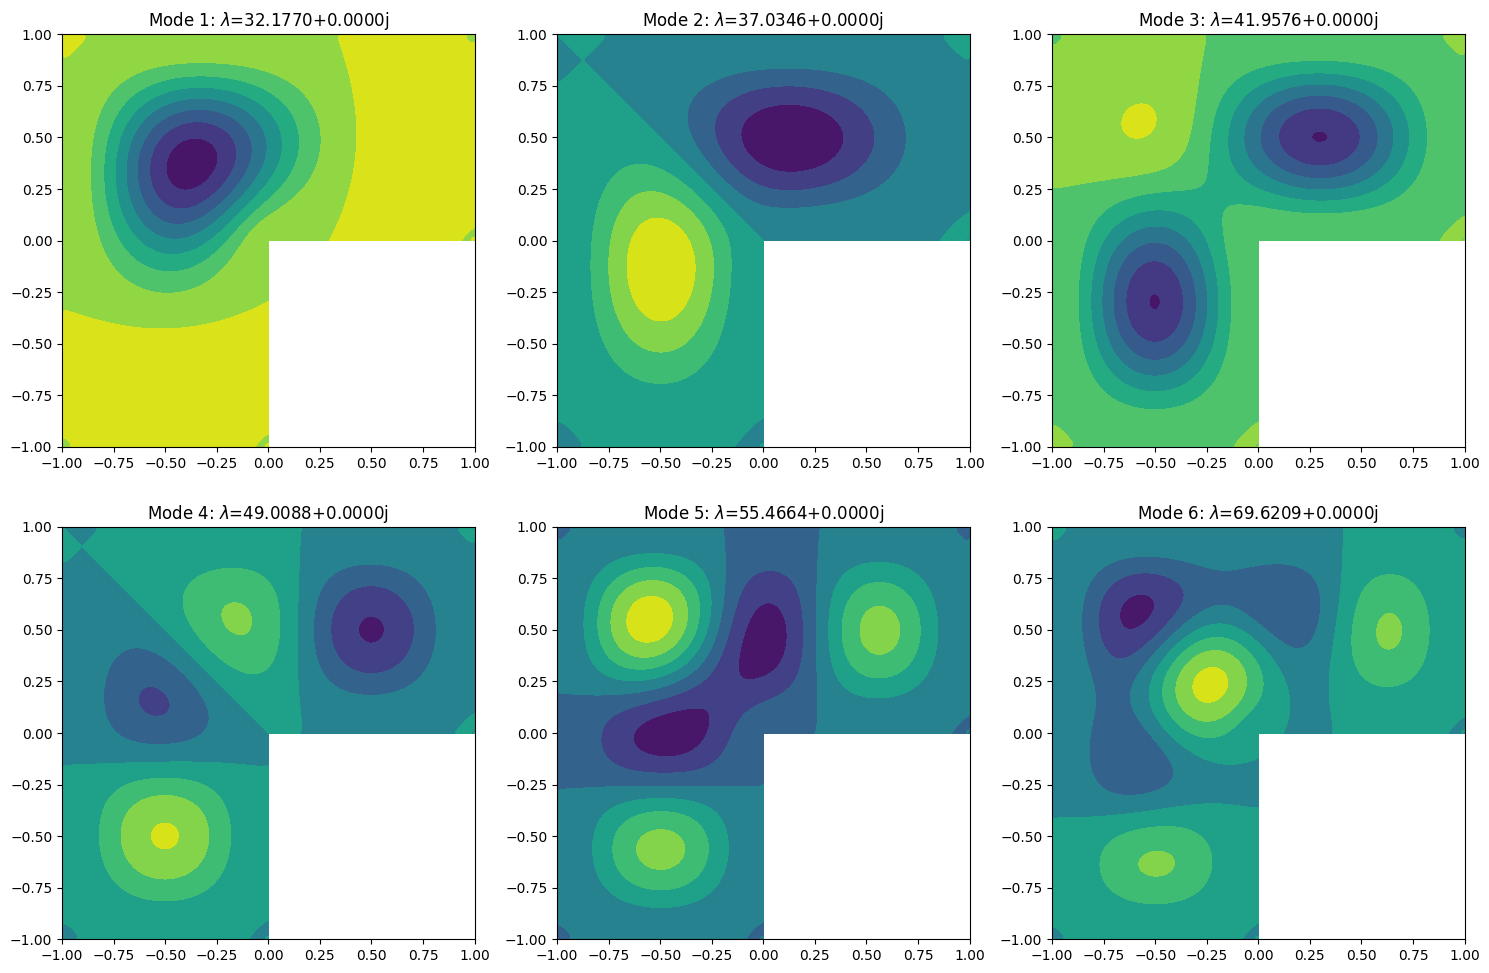

In [42]:
solve_stokes_eigenproblem(mesh_type="l-shaped", refinement_level=6, degree=2, sigma_val=64.0, ds_degree=0, penalty_only=False, n_eigenvalues=6, n_eigenfunctions=6)

Mesh: l-shaped | Refinement level: 6 | Degree: 2 | Sigma: 64.0
Found 7 eigenvalues.
Eigenvalue 0: (32.537531096420224+0j)
Eigenvalue 1: (37.182247412698906+0j)
Eigenvalue 2: (42.28890660817111+0j)
Eigenvalue 3: (49.49947521697452+0j)
Eigenvalue 4: (56.29274788429659+0j)
Eigenvalue 5: (70.53820837558632+0j)
Eigenvalue 6: (71.37632811248666+0j)


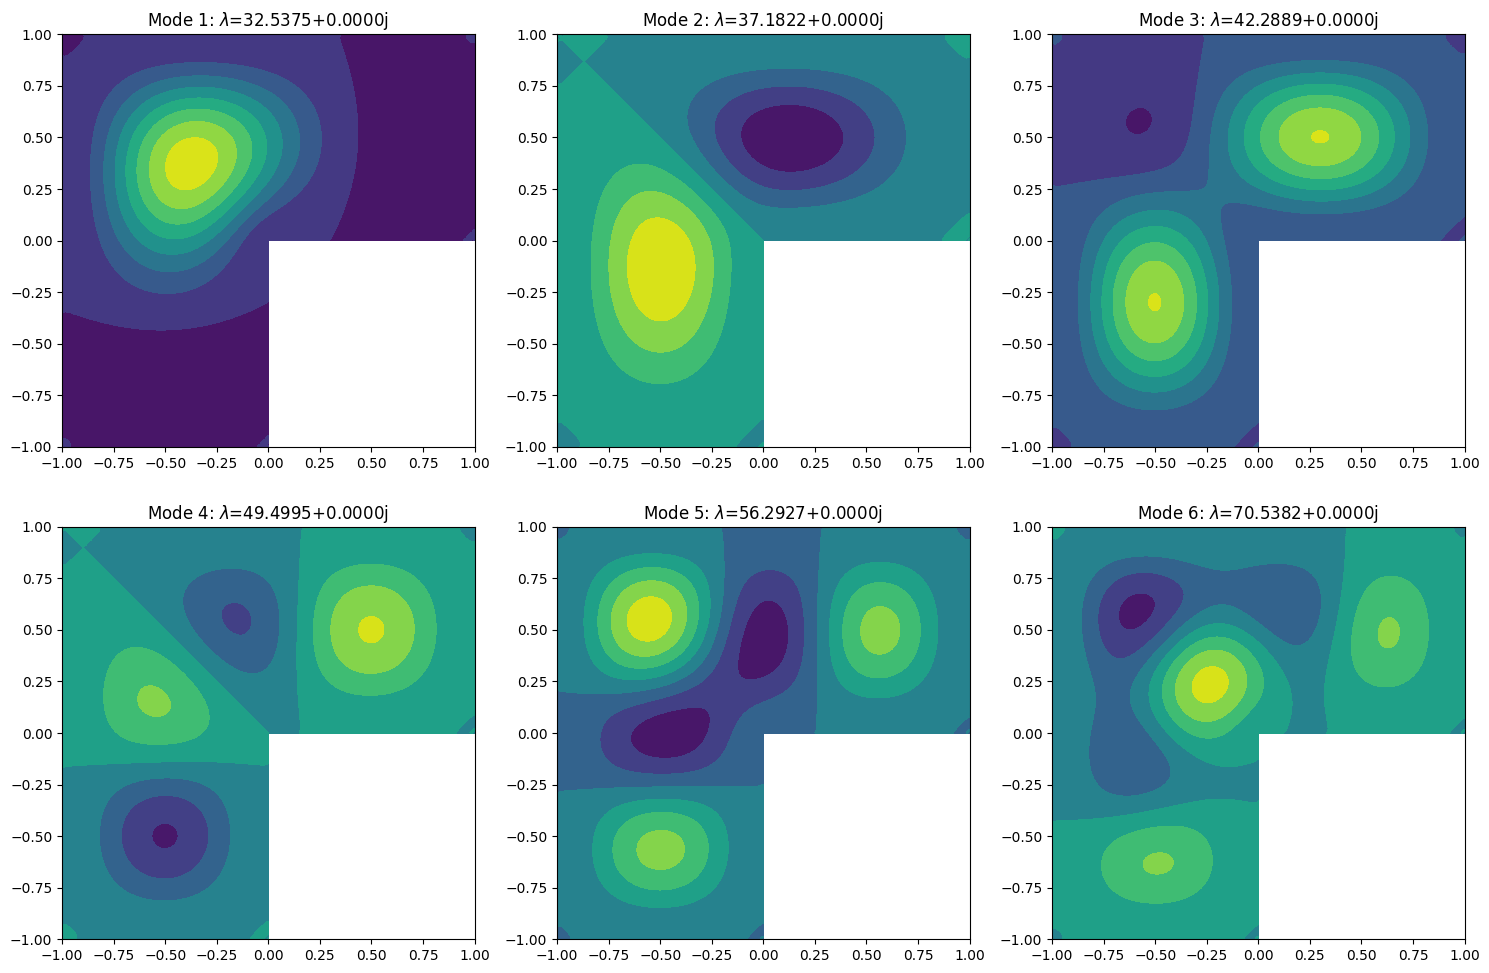

In [43]:
solve_stokes_eigenproblem(mesh_type="l-shaped", refinement_level=6, degree=2, sigma_val=64.0, ds_degree=None, penalty_only=False, n_eigenvalues=6, n_eigenfunctions=6)

Mesh: l-shaped | Refinement level: 3 | Degree: 2 | Sigma: 64.0
Found 7 eigenvalues.
Eigenvalue 0: (33.7985295004676+0j)
Eigenvalue 1: (38.66305694024196+0j)
Eigenvalue 2: (43.932472241722145+0j)
Eigenvalue 3: (51.688302852590915+0j)
Eigenvalue 4: (59.2695709887138+0j)
Eigenvalue 5: (76.02572498714744+0j)
Eigenvalue 6: (77.17671099759096+0j)


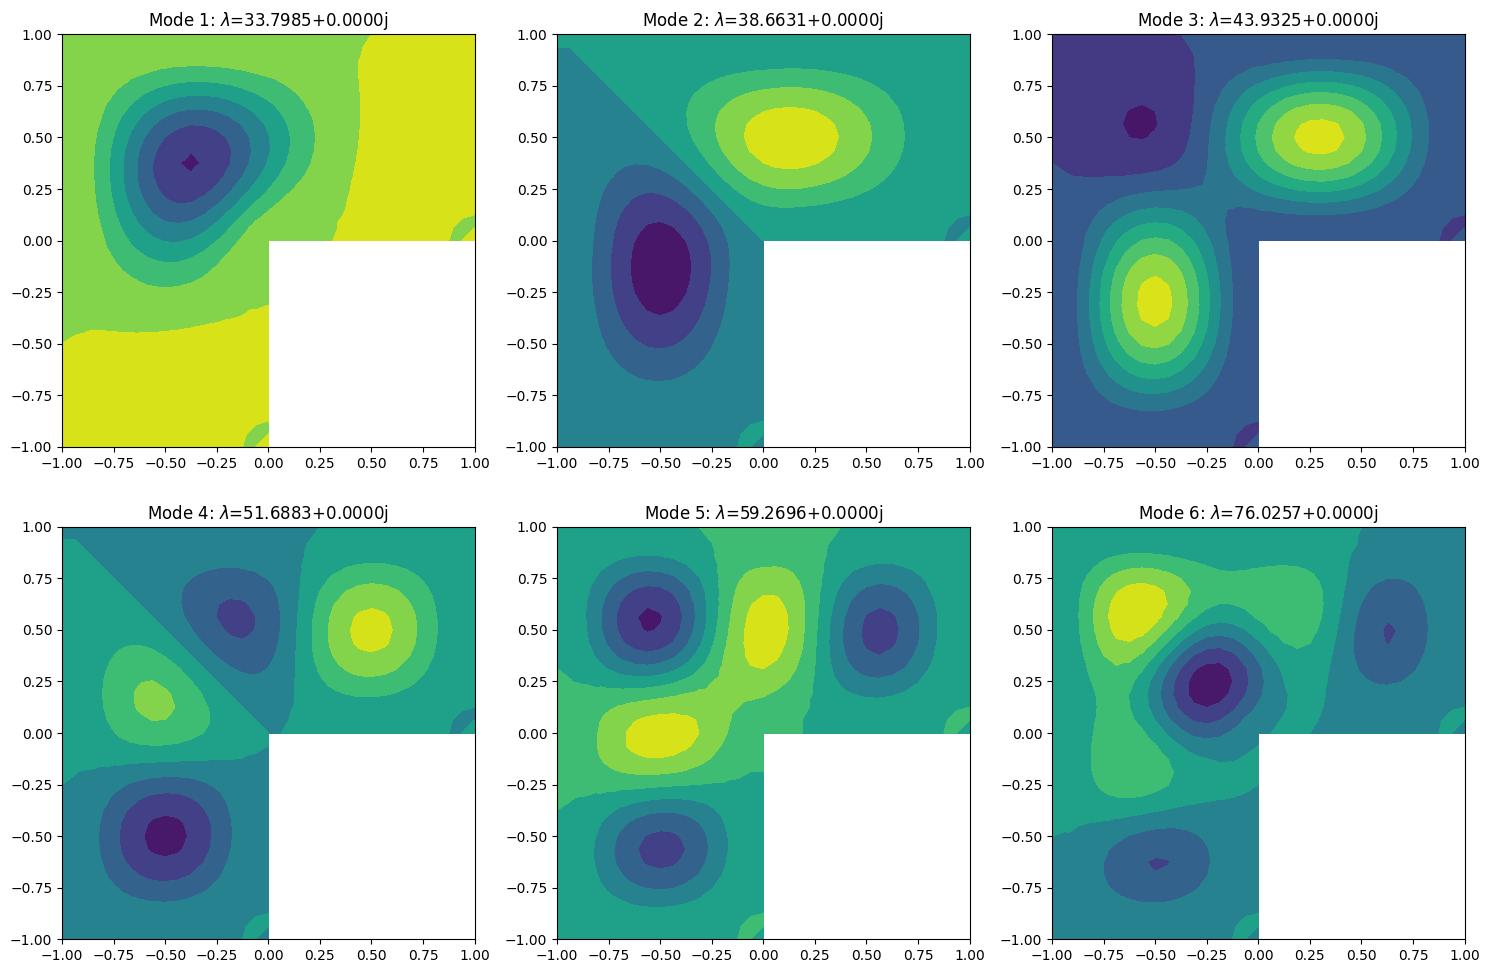

In [46]:
solve_stokes_eigenproblem(mesh_type="l-shaped", refinement_level=3, degree=2, sigma_val=64.0, ds_degree=0, penalty_only=False, n_eigenvalues=6, n_eigenfunctions=6)

Mesh: l-shaped | Refinement level: 3 | Degree: 2 | Sigma: 64.0
Found 9 eigenvalues.
Eigenvalue 0: (44.459294721416526+0j)
Eigenvalue 1: (45.700573502383264+0j)
Eigenvalue 2: (56.47373745913025+0j)
Eigenvalue 3: (69.53811736714502+0j)
Eigenvalue 4: (89.53664284988507+0j)
Eigenvalue 5: (101.55824838186582+0j)
Eigenvalue 6: (104.95451311262977+0j)
Eigenvalue 7: (110.06315298447872+0j)
Eigenvalue 8: (127.01093352222503+0j)


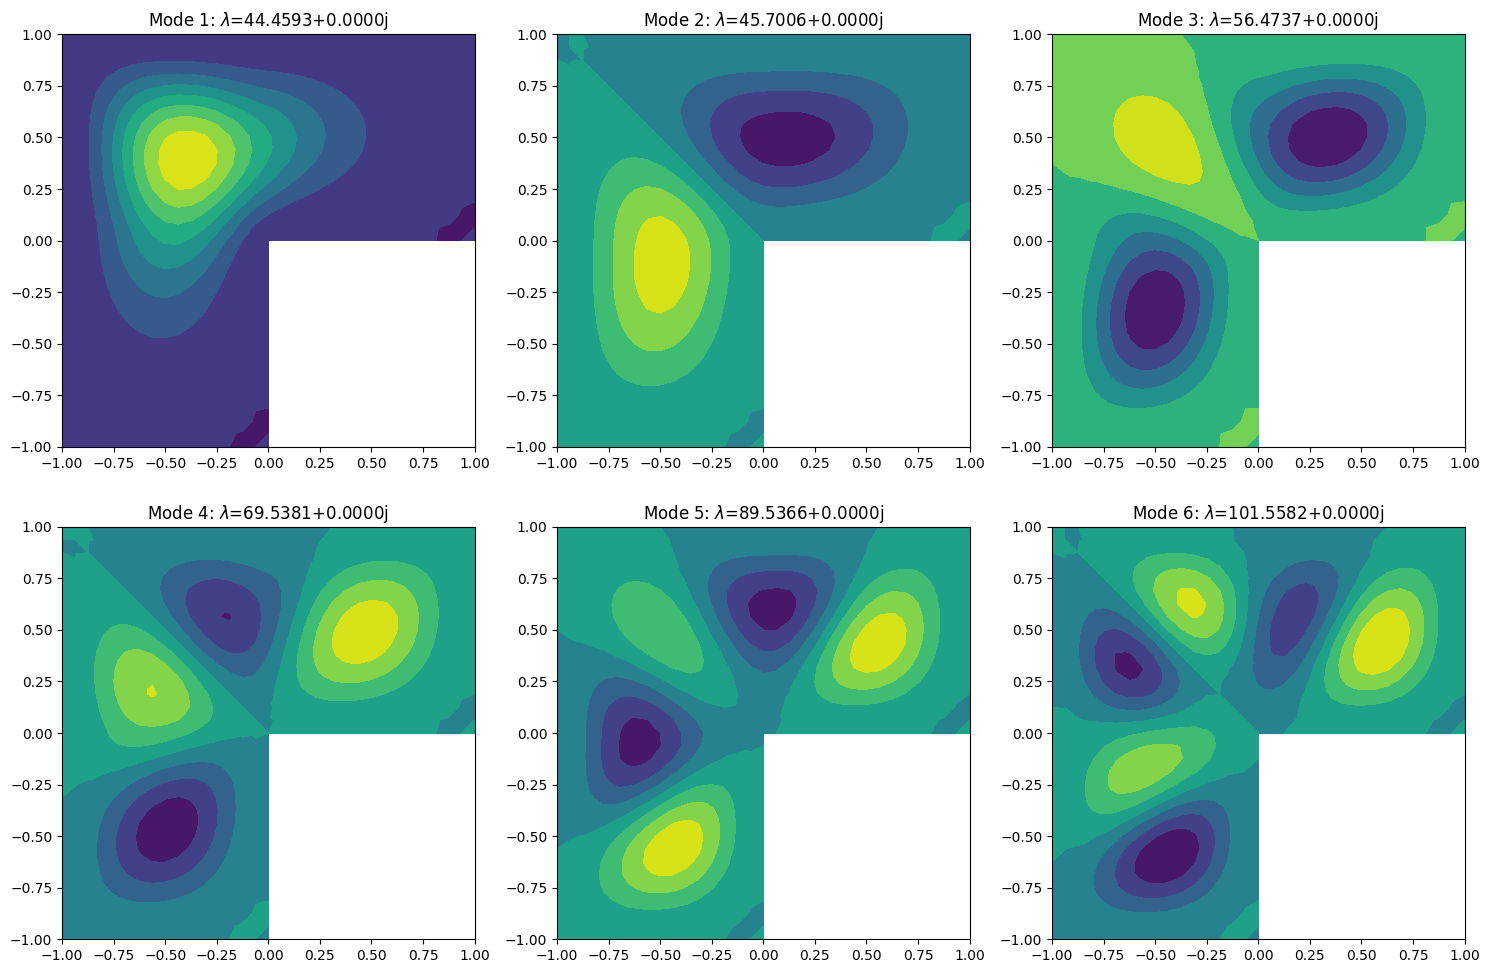

In [47]:
solve_stokes_eigenproblem(mesh_type="l-shaped", refinement_level=3, degree=2, sigma_val=64.0, ds_degree=None, penalty_only=False, n_eigenvalues=6, n_eigenfunctions=6)